In [1]:
import keras
keras.__version__

Using TensorFlow backend.
/home/sasaki/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sasaki/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sasaki/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sasaki/.local/lib/python3.6/site-packages/tensorflow/python

'2.3.1'

In [3]:
import os

data_dir = '/home/sasaki/Downloads/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [4]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

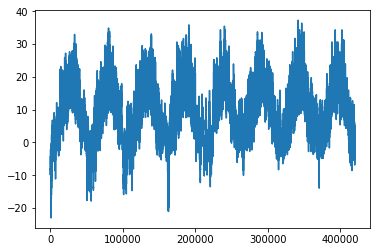

In [6]:
from matplotlib import pyplot as plt

temp = float_data[:, 1]  # temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)
plt.show()

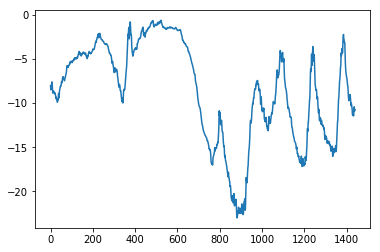

In [7]:
plt.plot(range(1440), temp[:1440])
plt.show()

In [8]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [9]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [20]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [11]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.2897359729905486


In [13]:
celsius_mae = 0.2897359729905486 * std[1]
print(celsius_mae)

2.564887434980494


In [14]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)


Epoch 1/20
500/500 [==============================] - 16s 32ms/step - loss: 1.4074 - val_loss: 0.5560
Epoch 2/20
500/500 [==============================] - 16s 31ms/step - loss: 0.4048 - val_loss: 0.2484
Epoch 3/20
500/500 [==============================] - 15s 31ms/step - loss: 0.2873 - val_loss: 0.2491
Epoch 4/20
500/500 [==============================] - 15s 31ms/step - loss: 0.2658 - val_loss: 0.2781
Epoch 5/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2529 - val_loss: 0.3448
Epoch 6/20
500/500 [==============================] - 16s 31ms/step - loss: 0.2471 - val_loss: 0.3190
Epoch 7/20
500/500 [==============================] - 15s 31ms/step - loss: 0.2394 - val_loss: 0.4166
Epoch 8/20
500/500 [==============================] - 16s 31ms/step - loss: 0.2334 - val_loss: 0.3127
Epoch 9/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2287 - val_loss: 0.3694
Epoch 10/20
500/500 [==============================] - 16s 32ms/step - loss: 0.22

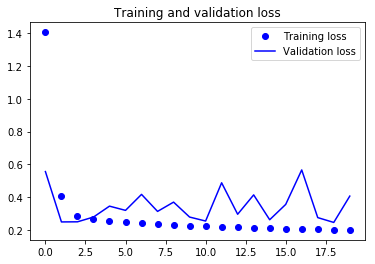

In [15]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [16]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 142s 283ms/step - loss: 0.3076 - val_loss: 0.1199
Epoch 2/20
500/500 [==============================] - 126s 252ms/step - loss: 0.2840 - val_loss: 0.1192
Epoch 3/20
500/500 [==============================] - 124s 249ms/step - loss: 0.2774 - val_loss: 0.1637
Epoch 4/20
500/500 [==============================] - 125s 249ms/step - loss: 0.2725 - val_loss: 0.1328
Epoch 5/20
500/500 [==============================] - 124s 248ms/step - loss: 0.2697 - val_loss: 0.1337
Epoch 6/20
500/500 [==============================] - 124s 248ms/step - loss: 0.2649 - val_loss: 0.1298
Epoch 7/20
500/500 [==============================] - 123s 247ms/step - loss: 0.2609 - val_loss: 0.1216
Epoch 8/20
500/500 [==============================] - 123s 247ms/step - loss: 0.2569 - val_loss: 0.1349
Epoch 9/20
500/500 [==============================] - 136s 272ms/step - loss: 0.2531 - val_loss: 0.1107
Epoch 10/20
500/500 [==============================] - 155s 310m

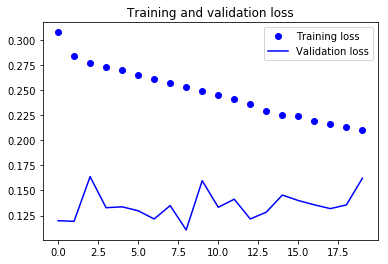

In [17]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [24]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
# 2020.01.30: delete recurrent_dropout parameter to avoid NAN
model.add(layers.GRU(32,
                     dropout=0.2,
#                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 144s 288ms/step - loss: 0.3347 - val_loss: 0.3601
Epoch 2/40
500/500 [==============================] - 137s 275ms/step - loss: 0.3065 - val_loss: 0.3079
Epoch 3/40
500/500 [==============================] - 138s 277ms/step - loss: 0.3007 - val_loss: 0.2701
Epoch 4/40
500/500 [==============================] - 134s 269ms/step - loss: 0.2952 - val_loss: 0.2412
Epoch 5/40
500/500 [==============================] - 131s 262ms/step - loss: 0.2919 - val_loss: 0.2077
Epoch 6/40
500/500 [==============================] - 131s 262ms/step - loss: 0.2877 - val_loss: 0.2268
Epoch 7/40
500/500 [==============================] - 132s 263ms/step - loss: 0.2862 - val_loss: 0.1785
Epoch 8/40
500/500 [==============================] - 133s 266ms/step - loss: 0.2838 - val_loss: 0.1942
Epoch 9/40
500/500 [==============================] - 127s 254ms/step - loss: 0.2804 - val_loss: 0.1701
Epoch 10/40
500/500 [==============================] - 127s 254m

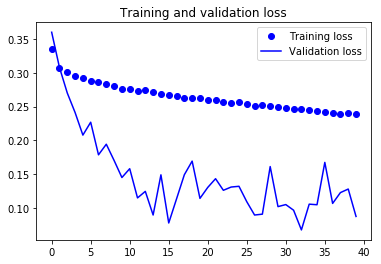

In [25]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [27]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
# 2020.01.30 delete recurrent_dropout param
model.add(layers.GRU(32,
                     dropout=0.1,
                     #recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
# 2020.01.30 delete recurrent_dropout param
"""
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
"""
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 344s 688ms/step - loss: 0.3230 - val_loss: 0.0713
Epoch 2/40
500/500 [==============================] - 333s 666ms/step - loss: 0.3023 - val_loss: 0.0567
Epoch 3/40
500/500 [==============================] - 332s 663ms/step - loss: 0.2962 - val_loss: 0.0764
Epoch 4/40
500/500 [==============================] - 331s 662ms/step - loss: 0.2862 - val_loss: 0.0592
Epoch 5/40
500/500 [==============================] - 326s 653ms/step - loss: 0.2799 - val_loss: 0.0913
Epoch 6/40
500/500 [==============================] - 326s 651ms/step - loss: 0.2752 - val_loss: 0.0539
Epoch 7/40
500/500 [==============================] - 327s 654ms/step - loss: 0.2713 - val_loss: 0.1552
Epoch 8/40
500/500 [==============================] - 327s 654ms/step - loss: 0.2659 - val_loss: 0.0683
Epoch 9/40
500/500 [==============================] - 324s 648ms/step - loss: 0.2616 - val_loss: 0.0504
Epoch 10/40
500/500 [==============================] - 322s 645m

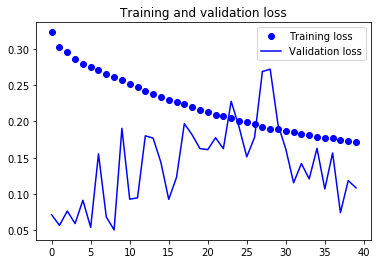

In [28]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()


In [29]:
def reverse_order_generator(data, lookback, delay, min_index, max_index,
                            shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets
        
train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step, 
    batch_size=batch_size)
val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

In [30]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen_reverse,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen_reverse,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 149s 298ms/step - loss: 0.4792 - val_loss: 0.1762
Epoch 2/20
500/500 [==============================] - 139s 278ms/step - loss: 0.4432 - val_loss: 0.1478
Epoch 3/20
500/500 [==============================] - 138s 276ms/step - loss: 0.4004 - val_loss: 0.2669
Epoch 4/20
500/500 [==============================] - 139s 278ms/step - loss: 0.3651 - val_loss: 0.2176
Epoch 5/20
500/500 [==============================] - 155s 311ms/step - loss: 0.3364 - val_loss: 0.1656
Epoch 6/20
500/500 [==============================] - 159s 318ms/step - loss: 0.3207 - val_loss: 0.1688
Epoch 7/20
500/500 [==============================] - 160s 319ms/step - loss: 0.3126 - val_loss: 0.1964
Epoch 8/20
500/500 [==============================] - 157s 314ms/step - loss: 0.3015 - val_loss: 0.1550
Epoch 9/20
500/500 [==============================] - 157s 315ms/step - loss: 0.2926 - val_loss: 0.1886
Epoch 10/20
500/500 [==============================] - 159s 318m

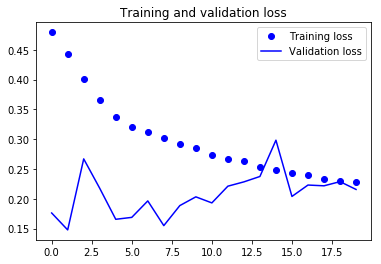

In [31]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [32]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

# Number of words to consider as features
max_features = 10000
# Cut texts after this number of words (among top max_features most common words)
maxlen = 500

# Load data
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Reverse sequences
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

# Pad sequences
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 87s 4ms/step - loss: 0.5036 - acc: 0.7550 - val_loss: 0.6052 - val_acc: 0.7924
Epoch 2/10
20000/20000 [==============================] - 87s 4ms/step - loss: 0.3177 - acc: 0.8769 - val_loss: 0.3180 - val_acc: 0.8832
Epoch 3/10
20000/20000 [==============================] - 86s 4ms/step - loss: 0.2657 - acc: 0.9014 - val_loss: 0.3243 - val_acc: 0.8744
Epoch 4/10
20000/20000 [==============================] - 86s 4ms/step - loss: 0.2239 - acc: 0.9183 - val_loss: 0.3273 - val_acc: 0.8856
Epoch 5/10
20000/20000 [==============================] - 85s 4ms/step - loss: 0.1940 - acc: 0.9311 - val_loss: 0.3266 - val_acc: 0.8810
Epoch 6/10
20000/20000 [==============================] - 86s 4ms/step - loss: 0.1746 - acc: 0.9373 - val_loss: 0.3764 - val_acc: 0.8710
Epoch 7/10
20000/20000 [===========

In [33]:
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 85s 4ms/step - loss: 0.5768 - acc: 0.7099 - val_loss: 0.4365 - val_acc: 0.8274
Epoch 2/10
20000/20000 [==============================] - 84s 4ms/step - loss: 0.3403 - acc: 0.8691 - val_loss: 0.3274 - val_acc: 0.8832
Epoch 3/10
20000/20000 [==============================] - 83s 4ms/step - loss: 0.2759 - acc: 0.8975 - val_loss: 0.4653 - val_acc: 0.8396
Epoch 4/10
20000/20000 [==============================] - 83s 4ms/step - loss: 0.2349 - acc: 0.9133 - val_loss: 0.3826 - val_acc: 0.8480
Epoch 5/10
20000/20000 [==============================] - 86s 4ms/step - loss: 0.2022 - acc: 0.9307 - val_loss: 0.3966 - val_acc: 0.8638
Epoch 6/10
20000/20000 [==============================] - 84s 4ms/step - loss: 0.1858 - acc: 0.9341 - val_loss: 0.3602 - val_acc: 0.8826
Epoch 7/10
20000/20000 [==============================] - 84s 4ms/step - loss: 0.1635 - acc: 0.9464 - val_loss: 0.8242 - val_acc:

In [34]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 159s 318ms/step - loss: 0.2923 - val_loss: 0.3495
Epoch 2/40
500/500 [==============================] - 157s 314ms/step - loss: 0.2717 - val_loss: 0.3946
Epoch 3/40
500/500 [==============================] - 153s 306ms/step - loss: 0.2665 - val_loss: 0.3160
Epoch 4/40
500/500 [==============================] - 153s 305ms/step - loss: 0.2620 - val_loss: 0.3665
Epoch 5/40
500/500 [==============================] - 154s 307ms/step - loss: 0.2546 - val_loss: 0.3412
Epoch 6/40
500/500 [==============================] - 153s 305ms/step - loss: 0.2496 - val_loss: 0.3725
Epoch 7/40
500/500 [==============================] - 151s 301ms/step - loss: 0.2441 - val_loss: 0.4241
Epoch 8/40
500/500 [==============================] - 153s 307ms/step - loss: 0.2373 - val_loss: 0.4036
Epoch 9/40
500/500 [==============================] - 154s 307ms/step - loss: 0.2301 - val_loss: 0.4290
Epoch 10/40
500/500 [==============================] - 153s 307m